In [3]:
import matplotlib.pyplot as plt
import torch
import geoopt

Radius: tensor(5.0629) tensor(5.9092) tensor([5.9092])
Analytic radius: tensor(2.9546) tensor(2.9546) tensor([2.9546])


(-1.0994713455438614,
 1.0999748259782791,
 -1.0998615264892577,
 1.0998615264892577)

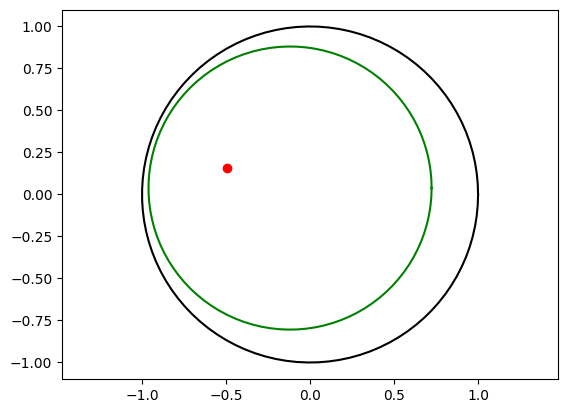

In [248]:
# Plot a circle on the Poincare disk

CHECK_RADIUS = True

# Randomly sampled origin
origin = torch.rand(2) * 2 - 1
while origin.norm() > 1:
    origin = torch.rand(2) * 2 - 1
# origin = torch.zeros(2)
# origin = torch.tensor([torch.rand(1).item() * 2 - 1, 0])

# We want a radius
radius = torch.rand(1) * 4


# Start with a circle
def pd_circle(origin, radius, num_points=100):
    _x = torch.linspace(-1, 1, num_points).unsqueeze(1)
    _y = torch.sqrt(1 - _x**2)
    _xy1 = torch.hstack((_x, _y))
    _xy2 = torch.hstack((_x, -_y)).flip(0)
    circ_coords = torch.vstack((_xy1, _xy2)) * radius
    # print(circ_coords.shape)

    # Make these elements of the tangent plane and move to the origin
    pd = geoopt.PoincareBall()
    circ_trans = pd.transp(torch.zeros(2), origin, circ_coords)
    circ_map = pd.expmap(origin, circ_trans)
    if CHECK_RADIUS:
        print("Radius:", pd.dist(origin, circ_map).min(), pd.dist(origin, circ_map).max(), 2 * radius)
    return circ_map.numpy(), _x.numpy(), _y.numpy()


# circ_map = circ_map.numpy()
circ_map, _x, _y = pd_circle(origin, radius)


# Analytic solution
def analytic_circle(r, c):
    k = torch.tanh(r / 2)
    # k = torch.tanh(radius)
    c_norm = torch.linalg.norm(c)
    c_prime = (1 - k**2) * c / (1 - k**2 * c_norm**2)
    r_prime = k * (1 - c_norm**2) / (1 - k**2 * c_norm**2)
    theta = torch.linspace(0, 2 * torch.pi, 100)
    x_circle = r_prime * torch.cos(theta)
    y_circle = r_prime * torch.sin(theta)
    circ_analytic = torch.stack([x_circle, y_circle], dim=1) + c_prime
    if CHECK_RADIUS:
        pd = geoopt.PoincareBall()
        print("Analytic radius:", pd.dist(c, circ_analytic).min(), pd.dist(c, circ_analytic).max(), radius)
    return circ_analytic.numpy(), r_prime, c_prime


circ_analytic, _, _ = analytic_circle(radius, origin)

# Plot the circle itself
plt.scatter(*origin, color="red")
# plt.plot(circ_map[:, 0], circ_map[:, 1], color="blue")
plt.plot(circ_analytic[:, 0], circ_analytic[:, 1], color="green")

# Plot the boundary
theta = torch.linspace(0, 2 * torch.pi, 100)
x_circle = torch.cos(theta)
y_circle = torch.sin(theta)
plt.plot(x_circle, y_circle, color="black")

# Equal aspect ratio
plt.axis("equal")

Analytic radius: tensor(2.1603) tensor(2.1603) tensor([2.9546])
Analytic radius: tensor(0.5443) tensor(0.5443) tensor([2.9546])


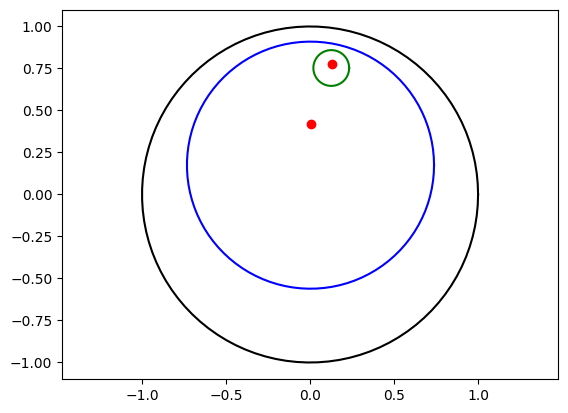

In [313]:
# Do two points at the same time

r1 = torch.rand(1) * 4
r2 = torch.rand(1) * 4
c1 = torch.rand(2) * 2 - 1
c2 = torch.rand(2) * 2 - 1
while c1.norm() > 1:
    c1 = torch.rand(2) * 2 - 1
while c2.norm() > 1:
    c2 = torch.rand(2) * 2 - 1


circ1, r1p, c1p = analytic_circle(r1, c1)
circ2, r2p, c2p = analytic_circle(r2, c2)

plt.scatter(*c1, color="red")
plt.scatter(*c2, color="red")
plt.plot(circ1[:, 0], circ1[:, 1], color="blue")
plt.plot(circ2[:, 0], circ2[:, 1], color="green")

# Plot the boundary
theta = torch.linspace(0, 2 * torch.pi, 100)
x_circle = torch.cos(theta)
y_circle = torch.sin(theta)
plt.plot(x_circle, y_circle, color="black")
plt.axis("equal")


# Define the intersection function for circles
def circle_intersections(c1, r1, c2, r2):
    x1, y1 = c1
    x2, y2 = c2

    # Calculate the distance between the centers
    d = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    # Check if there are no intersections
    if d > r1 + r2 or d < abs(r1 - r2) or d == 0:
        return None  # No intersection

    # Distance from c1 to the point on the line between intersections
    a = (r1**2 - r2**2 + d**2) / (2 * d)

    # Midpoint between the intersections
    pm_x = x1 + a * (x2 - x1) / d
    pm_y = y1 + a * (y2 - y1) / d

    # Distance from the midpoint to the intersection points
    h = (r1**2 - a**2) ** 0.5

    # Offsets for intersection points
    offset_x = h * (y2 - y1) / d
    offset_y = h * (x2 - x1) / d

    # Intersection points
    p1 = (pm_x + offset_x, pm_y - offset_y)
    p2 = (pm_x - offset_x, pm_y + offset_y)

    return p1, p2


# Compute the intersections
midpoint = circle_intersections(c1, r1, c2, r2)
if midpoint is not None:
    p1, p2 = midpoint
    plt.scatter(*p1, color="purple")
    plt.scatter(*p2, color="purple")

plt.show()

In [284]:
print(r1, r1p, c1, c1p)
print(r2, r2p, c2, c2p)

tensor([2.2265]) tensor([0.4796]) tensor([ 0.6227, -0.5207]) tensor([ 0.3822, -0.3196])
tensor([2.9498]) tensor([0.6300]) tensor([-0.0439,  0.8321]) tensor([-0.0190,  0.3600])


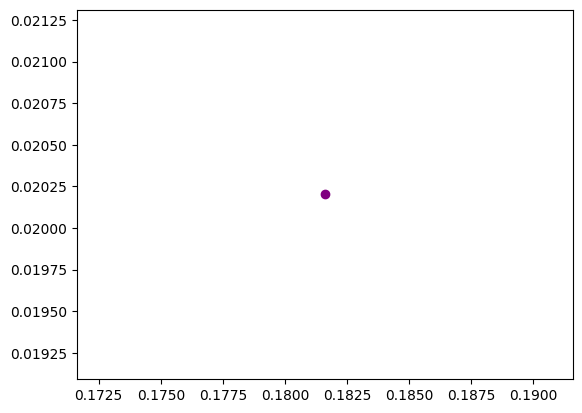

In [330]:
def find_geodesic(p1, p2):
    """Given two points, return the center and radius of the geodesic arc"""

    # Find inverse of p1
    p1_norm = torch.linalg.norm(p1) ** 2
    p3 = p1 / p1_norm

    # Convert everything to complex numbers
    p1_c = p1[0] + 1j * p1[1]
    p2_c = p2[0] + 1j * p2[1]
    p3_c = p3[0] + 1j * p3[1]

    # Find the circle
    w = (p3_c - p1_c) / (p2_c - p1_c)
    c = (p2_c - p1_c) * (w - abs(w) ** 2) / (2j * w.imag) + p1_c
    r = abs(p1_c - c)

    # Convert back to real numbers
    c = torch.tensor([c.real, c.imag])
    r = torch.tensor(r)

    # Get degrees of the arc by convertin p1 and p2 to angles
    p1_angle = torch.atan2(p1[1] - c[1], p1[0] - c[0]) * 180 / torch.pi % 360
    p2_angle = torch.atan2(p2[1] - c[1], p2[0] - c[0]) * 180 / torch.pi % 360
    # p1_angle = torch.atan2(p1[1] - c[1], p1[0] - c[0]) * 180 / torch.pi
    # p2_angle = torch.atan2(p2[1] - c[1], p2[0] - c[0]) * 180 / torch.pi

    # return c, r, p1_angle, p2_angle
    print(c)
    return f"({p1[0].item():.4f}, {p1[1].item():.4f}) arc ({p1_angle.item():.4f}:{p2_angle.item():.4f}:{r.item():.4f})"


p1 = torch.tensor([0.8038, 0])
p2 = torch.tensor([0.3333, -0.6547])
print(f"\draw[thick, color=green] {find_geodesic(p1, p2)};")

tensor([ 1.0239, -0.6546])
\draw[thick, color=green] (0.8038, 0.0000) arc (108.5875:180.0067:0.6906);


/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_91231/3409217699.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r)


In [331]:
p1 = torch.tensor([0.6227, -0.5207])
p2 = torch.tensor([-0.0439, 0.8321])
print(f"\draw[thick, color=green] {find_geodesic(p1, p2)};")

tensor([2.2841, 1.1386])
\draw[thick, color=green] (0.6227, -0.5207) arc (224.9637:187.5004:2.3481);


/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_91231/3409217699.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r)


In [339]:
# On the circle with center [2.2841, 1.1386] with radius 2.3481, what is the point closest to (0, 0)?

# Well, it lies on the line from the origin to the center, so we can just scale the center by the radius
center = torch.tensor([2.2841, 1.1386])
radius = 2.3481

# The line from the origin to the center
_vals = torch.linspace(0, 1, 100).unsqueeze(1)
_y = _vals * center

# Which point has distance to center equal to the radius?
# Use quadratic formula to get the norm of your point
# A = 1
# B = -2
# C = 1 - radius**2 / center.norm()**2
A = 1
B = -2
C = 1 - radius**2 / center.norm()**2
discriminant = B**2 - 4 * A * C
t = (-B - torch.sqrt(discriminant)) / (2 * A)
point = t * center
print(point)

tensor([0.1826, 0.0910])


In [340]:
# Get geodesics to your intersections
ancestor = torch.tensor([0.1826, 0.0910])
int1 = torch.tensor([0.5650, 0.1238])
int2 = torch.tensor([-0.0943, -0.2655])
print(f"\draw[thick, color=green] {find_geodesic(ancestor, int1)};")
print(f"\draw[thick, color=green] {find_geodesic(ancestor, int2)};")

tensor([-0.1303,  5.9847])
\draw[thick, color=green] (0.1826, 0.0910) arc (273.0392:276.7658:5.9020);
tensor([ 4.6965, -3.7008])
\draw[thick, color=green] (0.1826, 0.0910) arc (139.9687:144.3570:5.8952);


/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_91231/3409217699.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r)
